# Milestone 6

In this milestone, we implement some of the extensions mentioned in Milestone 5.

## Recall of previous work

Please refer to the [Milestone 4 Report](https://github.com/ML4BD/milestone-4-roguesgallery/blob/master/reports/Milestone%204%20Report.pdf) and the [Milestone 4 Notebook](https://github.com/ML4BD/milestone-4-roguesgallery/blob/master/notebooks/Milestone04/m4_lernnavi_roguesgallery.ipynb) for more details.

---

In Milestone 4, our objective was to predict the level check success of students with respect to their behavior on the **Lernnavi** learning platform. 

To this end, we **pre-processed** the data by removing students identified as inactive using criteria such as least number of actions per week. Then we selected a subset of features for each student and transformed their data into time series.<br>
In an attempt to see if **regularity** helped categorize students into subgroups, we followed the procedure of [Shirvani Boroujeni, et al](https://infoscience.epfl.ch/record/218657/files/) to compute regularity features on online learning time series. We then clustered the students using the regularity metrics.<br>
Finally, we trained multiple time series **classifiers** to predict wether a student would pass a level check or not. One classifier was trained per cluster and one over the whole data. We used 2 different classification techniques.

## Implementations of this milestone

For this milestone, we are planning on taking another approach to solving our research question. Indeed, in the first milestone, we demonstrated the **predictive potential of a user's behavior time series** for its **success in level checks**. For this, we clustered with respect to time-agnostic metrics and then classified the time series.

Our second approach will be to cluster with respect to user time series and then classify using features derived from the markov modeling of users' behaviors.

To this end, we will proceed as follows:

1. Separate math and german-related actions in the data.

2. Cluster the user's behaviors using time series clustering.

3. Apply the markov chain modeling to the sequence of actions for each user.

4. Train a logistic regression on the markov chain representation of the data.


## Data Processing

### Clustering the user's behaviors using time series clustering

#### Libraries used

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import jensenshannon
from scipy import stats
from scipy.sparse.csgraph import laplacian
from scipy import linalg

from datetime import timedelta, datetime 

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from tslearn.metrics import dtw, softdtw

ImportError: cannot import name 'softdtw' from 'tslearn.metrics' (/usr/local/lib/python3.8/dist-packages/tslearn/metrics/__init__.py)

#### Data Loading

In [77]:
DATA_DIR = './data'

In [78]:
df = pd.read_csv('{}/data.csv.gz'.format(DATA_DIR))
topics_translated = pd.read_csv('{}/topics_translated.csv.gz'.format(DATA_DIR))

In [79]:
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6


In [6]:
df['topic_id']

0         3250
1         3250
2         3250
3         3250
4         3250
          ... 
790420    1031
790421    1035
790422    1035
790423    1031
790424    1031
Name: topic_id, Length: 790425, dtype: int64

In [8]:
topics_translated.head()

,id,name,description,name_english,description_english,math
0,1,Deutsch,Sprache als System,German,Language as a system,0.0
1,2,Orthografie,NaN,spelling,NaN,0.0
2,3,Rechtschreibprinzipien,NaN,Spelling principles,NaN,0.0
3,109,Mathematik,Rechnen und so...,mathematics,Expect and so ...,1.0
4,950,Zahlen und Zahlenmengen,NaN,Numbers and number quantities,NaN,1.0


In [11]:
topcis_translated = topics_translated.rename(columns = {'id':'topic_id'}, inplace = True)

In [12]:
topics_translated.head()

,topic_id,name,description,name_english,description_english,math
0,1,Deutsch,Sprache als System,German,Language as a system,0.0
1,2,Orthografie,NaN,spelling,NaN,0.0
2,3,Rechtschreibprinzipien,NaN,Spelling principles,NaN,0.0
3,109,Mathematik,Rechnen und so...,mathematics,Expect and so ...,1.0
4,950,Zahlen und Zahlenmengen,NaN,Numbers and number quantities,NaN,1.0


In [13]:
df = df.merge(topics_translated, on = ['topic_id'])

In [14]:
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user,name,description,name_english,description_english,math
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,5,40,7,6,Beziehung zwischen Satzgliedern/Attributen und...,NaN,Relationship between phrases / attributes and ...,NaN,0.0
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,NaN,5,40,7,6,Beziehung zwischen Satzgliedern/Attributen und...,NaN,Relationship between phrases / attributes and ...,NaN,0.0
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,NaN,5,40,7,6,Beziehung zwischen Satzgliedern/Attributen und...,NaN,Relationship between phrases / attributes and ...,NaN,0.0
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,NaN,5,40,7,6,Beziehung zwischen Satzgliedern/Attributen und...,NaN,Relationship between phrases / attributes and ...,NaN,0.0
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,NaN,5,40,7,6,Beziehung zwischen Satzgliedern/Attributen und...,NaN,Relationship between phrases / attributes and ...,NaN,0.0


In [20]:
df = df.drop(columns = ['topic_id', 'name', 'description', 'name_english', 'description_english'])
df.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user,math
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6,0.0
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6,0.0
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6,0.0
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6,0.0
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6,0.0


In [24]:
df_math = df[df['math'] == 1.0]
df_german = df[df['math'] == 0.0]
df_math = df_math.drop(columns = ['math'])
df_german = df_german.drop(columns = ['math'])

In [25]:
df_math.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
265833,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 08:11:13.272,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265834,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:02.900,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265835,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:06.952,SESSION,SKIP,CLICK,37243.0,NaN,5,6,16,6
265836,729363,26841d0e-d75d-409f-9428-91c17c42ad29,387604.0,aQq2jyhkdgI9MjRzTxM1sy,80849,NaN,NaN,1625217067086,1.625217e+12,unknown,...,2021-07-02 09:11:07.174,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265837,729363,26841d0e-d75d-409f-9428-91c17c42ad29,387604.0,aQq2jyhkdgI9MjRzTxM1sy,80849,NaN,NaN,1625217067086,1.625217e+12,unknown,...,2021-07-02 09:11:08.591,SESSION,SKIP,CLICK,37243.0,NaN,5,6,16,6


In [26]:
df_german.head()

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,timestamp,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
0,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:38.387,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
1,1576010,a65959df-7bf0-4956-9aa7-511af281fdb5,387604.0,18FedrGurdA7jklbk0mtVA,115404,NaN,NaN,1645197218251,1.645197e+12,unknown,...,2022-02-18 15:13:40.545,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6
2,1576012,379dad17-2d6f-42f3-b6f0-68a39664733b,387604.0,1taQDeFXg1E9GxbT0YApJU,115407,NaN,NaN,1645197222948,NaN,unknown,...,2022-02-18 15:13:43.057,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
3,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:30.415,SESSION,REVIEW_TASK,VIEW,111059.0,NaN,5,40,7,6
4,1576009,5094da67-0959-46b4-bb4a-03b5d55259fa,387604.0,81qKZ40TTAx6YsQPzKE5kx,116432,NaN,NaN,1645197210317,1.645197e+12,unknown,...,2022-02-18 15:13:37.975,SESSION,SKIP,CLICK,111059.0,NaN,5,40,7,6


#### Regularity metrics computation

In [27]:
def similarity_days(wi, wj):
    m1, m2 = np.where(wi == 1)[0], np.where(wj == 1)[0]
    if len(m1) == 0 or len(m2) == 0:
        return 0
    return len(np.intersect1d(m1, m2)) / max(len(m1), len(m2))

In [28]:
def chi2_divergence(p1, p2, a1, a2):
    a = p1 - p2
    b = p1 + p2
    frac = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b != 0)
    m1 = np.where(a1 > 0)[0]
    m2 = np.where(a2 > 0)[0]
    union = set(m1) & set(m2)
    if len(union) == 0: return np.nan
    return 1 - (1 / len(union)) * np.sum(np.square(frac))

In [29]:
def time_measures(data, mode, weeks):
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the dayhour mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(24) - entropy) * np.max(activity)
    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        if np.sum(activity) == 0:
            print("Feature is invalid: the weekday mode is invalid. Returning nan.")
            return np.nan
        entropy = stats.entropy(activity / np.sum(activity))
        return (np.log(7) - entropy) * np.max(activity)

In [30]:
def time_measures_plot_student(student, data, mode, weeks):
    data = data[data['user_id'] == student]
    data = data[data['week'] < weeks]
    if mode == 'dayhour':
        hours = data['date'].dt.hour.astype(int).to_list()
        activity = np.array([hours.count(h) for h in np.arange(24)])
        time_measure_data = pd.DataFrame({'hour' : np.arange(24), 'count' : activity})
        
        time_measure_data.plot.bar(x='hour', y='count', rot=0)
        plt.xlabel("Hour of day")
        plt.ylabel("Count")

    elif mode == 'weekday':
        weekdays = data['date'].dt.weekday.astype(int).to_list()
        activity = np.array([weekdays.count(h) for h in np.arange(7)])
        time_measure_data = pd.DataFrame({'weekday' : np.arange(7), 'count' : activity})
        
        time_measure_data.plot.bar(x='weekday', y='count', rot=0)
        plt.xlabel("Day of week")
        plt.ylabel("Count")  

In [31]:
def create_week_number(d):
    return (d.isocalendar()[0] - 2021) * 53 + d.isocalendar()[1] - 1
# https://stackoverflow.com/questions/59425176/how-to-continue-the-week-number-when-the-year-changes-using-pandas

In [32]:
def profile_similarity(data, mode, weeks):
    data['weekday'] = data['date'].dt.weekday.astype(int)
    data = data[data['week'] < weeks]
    
    workload = np.zeros((weeks, 7))
    workload[data['week'], data['weekday']] += 1
    hist = workload / np.sum(workload)

    # Hours of activity starting at midnight of the first timestamp
    hours = (data['date']).values.astype(np.int64) // 10 ** 9 // 3600
    min_day = data.date.min() # First day of activity
    # Make the hours start from midnight of the first day
    hours -= int(datetime(min_day.year, min_day.month, min_day.day).timestamp() / 3600)

    period_length = weeks * 7 * 24
    activity = np.array([int(t in hours) for t in range(period_length)]).reshape((weeks, 7 * 24))
    activity = np.array([week.reshape((7, 24)).sum(axis=1) for week in activity])  # shape (weeks, 7)
    if mode == 'm1':
        return np.mean([similarity_days(workload[i], workload[j]) for i in range(workload.shape[0]) for j in range(i+1, workload.shape[0])])
    elif mode == 'm2':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(1 - jensenshannon(activity[i], activity[j], 2.0))
        if len(res) == 0:
            #print("Feature is invalid. Will return nan")
            return np.nan
        return np.mean(np.clip(np.nan_to_num(res), 0, 1))
    elif mode == 'm3':
        res = []
        for i in range(activity.shape[0]):
            for j in range(i + 1, activity.shape[0]):
                if not activity[i].any() or not activity[j].any():
                    continue
                res.append(chi2_divergence(activity[i], activity[j], hist[i], hist[j]))
        if len(res) == 0:
            return np.nan
        return np.mean(np.nan_to_num(res))

In [33]:
def fourier_transform(Xi, f, n):
    return np.dot(np.exp(-2j * np.pi * f * n), Xi)

In [34]:
def freq(data, mode, weeks):
    if mode == 'm1':
        # Convert date to hours starting from 0
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        period_length = weeks * 7 * 24
        activity = np.array([int(t in hours) for t in range(period_length)])  # 1 if active at hour t 0 o.w.
        if np.sum(activity) == 0:
            #logging.debug('feature {} is invalid: the m1 mode is invalid'.format(self.name))
            return np.nan #Feature.INVALID_VALUE
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 24, n))

    elif mode == 'm2':
        period_length = weeks * 7 * 24
        hours = data['date'].values.astype(np.int64) // 10 ** 9 // 3600
        hours -= min(hours)
        activity = np.array([int(t in hours) for t in range(period_length)])
        n = np.arange(period_length)
        return abs(fourier_transform(activity.flatten(), 1 / (7 * 24), n))

    elif mode == 'm3':
        # Convert date to days starting from 0
        days = data['date'].values.astype(np.int64) // 10 ** 9 // (24 * 3600)
        days -= min(days)
        period_length = weeks * 7
        activity = np.array([int(d in days) for d in range(period_length)])  # 1 if active at day d 0 o.w.
        n = np.arange(period_length)
        return abs(fourier_transform(activity, 1 / 7, n))

In [35]:
def compute_agg_regularity(data, weeks):
    
    #time based measures
    PDH = data.groupby('user_id').apply(lambda x: time_measures(x, 'dayhour', weeks)).reset_index()
    PWD = data.groupby('user_id').apply(lambda x: time_measures(x, 'weekday', weeks)).reset_index(drop=True)
    
    #profile similarity 
    WS1 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm1', weeks)).reset_index(drop=True)
    WS2 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm2', weeks)).reset_index(drop=True)
    WS3 = data.groupby('user_id').apply(lambda x: profile_similarity(x, 'm3', weeks)).reset_index(drop=True)
    
    #frequency based measures
    FDH = data.groupby('user_id').apply(lambda x: freq(x, 'm1', weeks)).reset_index(drop=True)
    FWH = data.groupby('user_id').apply(lambda x: freq(x, 'm2', weeks)).reset_index(drop=True)
    FWD = data.groupby('user_id').apply(lambda x: freq(x, 'm3', weeks)).reset_index(drop=True)
    
    reg_features = pd.concat([PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD], axis=1, ignore_index=False)
    
    return reg_features 

In [36]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [38]:
data_clean = df_math
data_clean.rename(columns={'timestamp':'date'}, inplace=True)
data_clean['date'] = pd.to_datetime(data_clean['date'])
data_clean.head() #there seem to be duplicate rows 

,transaction_id,transaction_token,user_id,document_id,document_version,evaluation,input,start_time,commit_time,user_agent,...,date,category,action,event_type,session_id,tracking_data,num_participations,week,num_actions_per_week,num_weeks_per_user
265833,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 08:11:13.272,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265834,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:02.900,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265835,729269,d471b18d-8aec-45e8-a92e-6a2405ad700f,387604.0,7jtbzlKxycH6cW4AluHWvW,80848,NaN,NaN,1625213473122,1.625217e+12,unknown,...,2021-07-02 09:11:06.952,SESSION,SKIP,CLICK,37243.0,NaN,5,6,16,6
265836,729363,26841d0e-d75d-409f-9428-91c17c42ad29,387604.0,aQq2jyhkdgI9MjRzTxM1sy,80849,NaN,NaN,1625217067086,1.625217e+12,unknown,...,2021-07-02 09:11:07.174,TASK,VIEW_QUESTION,VIEW,37243.0,NaN,5,6,16,6
265837,729363,26841d0e-d75d-409f-9428-91c17c42ad29,387604.0,aQq2jyhkdgI9MjRzTxM1sy,80849,NaN,NaN,1625217067086,1.625217e+12,unknown,...,2021-07-02 09:11:08.591,SESSION,SKIP,CLICK,37243.0,NaN,5,6,16,6


In [39]:
#data_clean.info()
data_clean.drop(['start_time', 'commit_time'], axis=1, inplace=True)

In [48]:
no_weeks = max(data_clean.week) + 1
df_regularity = compute_agg_regularity(data_clean, no_weeks)

In [49]:
df_regularity.head()

,user_id,0,0,1,2,3,4,5,6
0,387604.0,13.637463,11.675461,0.000000,NaN,NaN,1.982890,1.999650,1.000000
1,387605.0,62.597640,42.422070,0.015292,0.162790,0.0,13.695300,10.383745,4.791290
2,387608.0,114.246372,21.449510,0.001161,0.100000,0.0,6.883195,2.297492,1.519203
3,387650.0,97.469260,49.102222,0.015970,0.245105,0.0,13.622891,5.177756,4.932190
4,387712.0,114.409938,70.052765,0.000000,NaN,NaN,1.000000,1.000000,1.000000


In [50]:
df_regularity.columns = ['user_id', 'PDH', 'PWD', 'WS1', 'WS2', 'WS3', 'FDH', 'FWH', 'FWD']
df_regularity.head()

,user_id,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
0,387604.0,13.637463,11.675461,0.000000,NaN,NaN,1.982890,1.999650,1.000000
1,387605.0,62.597640,42.422070,0.015292,0.162790,0.0,13.695300,10.383745,4.791290
2,387608.0,114.246372,21.449510,0.001161,0.100000,0.0,6.883195,2.297492,1.519203
3,387650.0,97.469260,49.102222,0.015970,0.245105,0.0,13.622891,5.177756,4.932190
4,387712.0,114.409938,70.052765,0.000000,NaN,NaN,1.000000,1.000000,1.000000


In [51]:
# Checking fraction of NaN values in each column
def check_NaNs(df):
    for c in df.columns:
        na_count = df_regularity[c].isna().sum()
        print(f"Column {c} contains {na_count} ({na_count*100 / df_regularity.shape[0]:.2f}%) NaN values.")

In [52]:
# Clustering techniques do not handle NaN values
# We define a NaN-handling functions

def handle_NaN(df, method = 'remove'):
    
    # remove all lines containing NaNs in any column
    if method == 'remove':
        mask = df_regularity.isna().apply(lambda r : any(r), axis=1)
        tmp = df.loc[~mask]
        return tmp
        
    # replace all NaNs with their columns means
    elif method == 'mean':
        means = df_regularity.apply(np.nanmean)
        tmp = df.where(~df_regularity.isna(), means, axis=1)
        return tmp
        
    elif method == 'median':
        medians = df_regularity.apply(np.nanmedian)
        tmp = df.where(~df_regularity.isna(), medians, axis=1)
        return tmp
        
    else :
        print("No method was indicated to handle NaN values!")
        return None

In [53]:
check_NaNs(df_regularity)

Column user_id contains 0 (0.00%) NaN values.
Column PDH contains 0 (0.00%) NaN values.
Column PWD contains 0 (0.00%) NaN values.
Column WS1 contains 0 (0.00%) NaN values.
Column WS2 contains 506 (36.83%) NaN values.
Column WS3 contains 506 (36.83%) NaN values.
Column FDH contains 0 (0.00%) NaN values.
Column FWH contains 0 (0.00%) NaN values.
Column FWD contains 0 (0.00%) NaN values.


In [54]:
# Handling NaNs using 'remove' method
df_regularity = handle_NaN(df_regularity)

In [55]:
check_NaNs(df_regularity)

Column user_id contains 0 (0.00%) NaN values.
Column PDH contains 0 (0.00%) NaN values.
Column PWD contains 0 (0.00%) NaN values.
Column WS1 contains 0 (0.00%) NaN values.
Column WS2 contains 0 (0.00%) NaN values.
Column WS3 contains 0 (0.00%) NaN values.
Column FDH contains 0 (0.00%) NaN values.
Column FWH contains 0 (0.00%) NaN values.
Column FWD contains 0 (0.00%) NaN values.


Scatter matrix of the regularity metrics (pairwise).


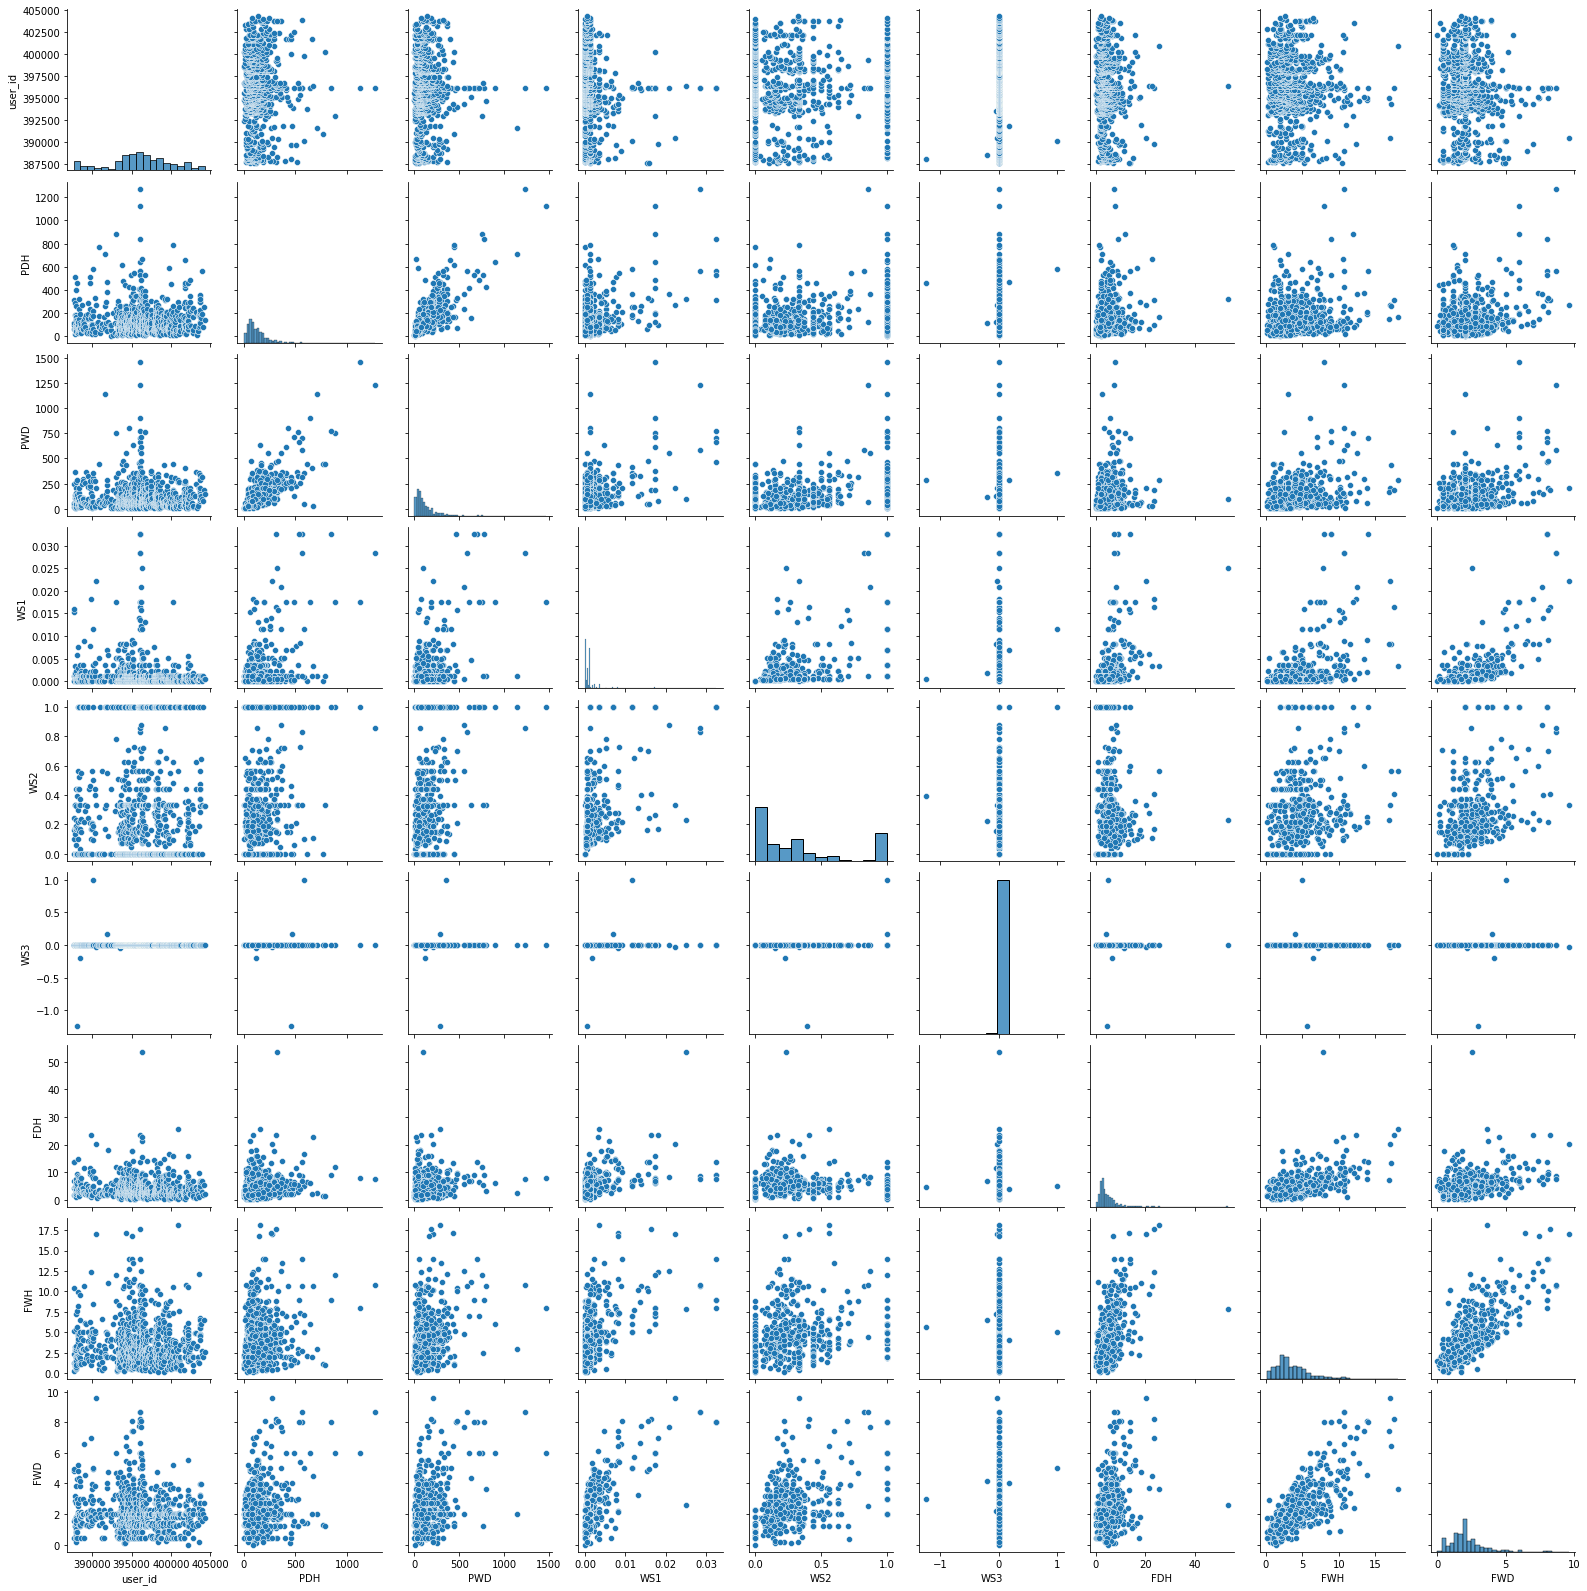

In [56]:
# Visualizing data
sns.pairplot(df_regularity)
print("Scatter matrix of the regularity metrics (pairwise).")
plt.show()

#### Time Series Clustering

In [57]:
# Preparing the data
X = df_regularity.drop(columns='user_id')
users = df_regularity.user_id

print("This is what a single feature vector for clustering looks like:")
X.head(1)

This is what a single feature vector for clustering looks like:


,PDH,PWD,WS1,WS2,WS3,FDH,FWH,FWD
1,62.59764,42.42207,0.015292,0.16279,0.0,13.6953,10.383745,4.79129


In [87]:
# Detecting optimal number of clusters
scores = []
k_max = 10
# Single cluster case excluded, we start from 2
ks = range(2, k_max+1)

for k in tqdm(ks):
    kmeans = TimeSeriesKMeans(n_clusters = k, metric = "euclidean").fit(X)
    labels = kmeans.labels_
    scores.append(silhouette_score(X, labels, metric = "euclidean"))

100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


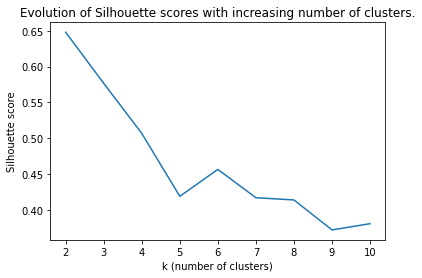

In [88]:
ax = sns.lineplot(x=ks, y=scores)
ax.set_title('Evolution of Silhouette scores with increasing number of clusters.')
ax.set_xlabel("k (number of clusters)")
ax.set_ylabel("Silhouette score")
plt.show()

In [94]:
# Detecting optimal number of clusters
scores = []
k_max = 10
# Single cluster case excluded, we start from 2
ks = range(2, k_max+1)

for k in tqdm(ks):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw").fit(X)
    labels = kmeans.labels_
    scores.append(silhouette_score(X, labels, metric = "dtw"))

100%|██████████| 9/9 [09:51<00:00, 65.77s/it]


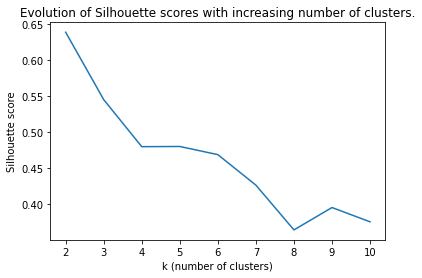

In [95]:
ax = sns.lineplot(x=ks, y=scores)
ax.set_title('Evolution of Silhouette scores with increasing number of clusters.')
ax.set_xlabel("k (number of clusters)")
ax.set_ylabel("Silhouette score")
plt.show()

In [96]:
# Detecting optimal number of clusters
scores = []
k_max = 10
# Single cluster case excluded, we start from 2
ks = range(2, k_max+1)

for k in tqdm(ks):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="softdtw").fit(X)
    labels = kmeans.labels_
    scores.append(silhouette_score(X, labels, metric = "softdtw"))

100%|██████████| 9/9 [16:45<00:00, 111.76s/it]


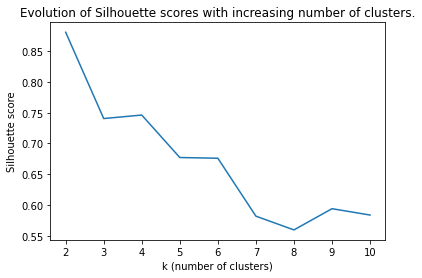

In [98]:
ax = sns.lineplot(x=ks, y=scores)
ax.set_title('Evolution of Silhouette scores with increasing number of clusters.')
ax.set_xlabel("k (number of clusters)")
ax.set_ylabel("Silhouette score")
plt.show()

## Model Building

## Model Evaluation